## Canonicalization of shapes

In [1]:
# load libraries
import trimesh
import torch
import json
import os
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from types import SimpleNamespace
from utils import render
from shapenet_dataloader import ShapeNetMesh
from deepdeform.layers.deformation_layer import NeuralFlowDeformer

## Options

In [2]:
# choice of checkpoint to load
run_dir = "runs/pretrained_ckpt"
checkpoint = "checkpoint_latest.pth.tar_deepdeform_100.pth.tar"
device = torch.device("cuda:0")

## Setup

In [5]:
# load training args
args = SimpleNamespace(**json.load(open(os.path.join(run_dir, 'params.json'), 'r')))

# dataloader
data_root = args.data_root
dset = ShapeNetMesh(data_root=data_root, split="train", category=args.category, normals=False)

# setup model
deformer = NeuralFlowDeformer(latent_size=args.lat_dims, f_width=args.deformer_nf, s_nlayers=2, 
                              s_width=5, method=args.solver, nonlinearity=args.nonlin, arch='imnet',
                              adjoint=args.adjoint, rtol=args.rtol, atol=args.atol, via_hub=True,
                              no_sign_net=(not args.sign_net), symm_dim=(2 if args.symm else None))
lat_params = torch.nn.Parameter(torch.randn(dset.n_shapes, args.lat_dims)*1e-1, requires_grad=True)
deformer.add_lat_params(lat_params)
deformer.to(device)

# load checkpoint
resume_dict = torch.load(os.path.join(run_dir, checkpoint))
start_ep = resume_dict["epoch"]
global_step = resume_dict["global_step"]
tracked_stats = resume_dict["tracked_stats"]
deformer.load_state_dict(resume_dict["deformer_state_dict"])

<All keys matched successfully>

## Canonicalization

In [12]:
lat_path = lambda l_src_, l_tar_: torch.stack([l_src_, l_tar_], dim=1)
ten2npy = lambda tensor: tensor.detach().cpu().numpy()

In [13]:
np.random.seed(5)
shape_indices = np.random.choice(4745, 5)  # choose between [0, 4745]
n = len(shape_indices)
imgs_src = [None for _ in range(n)]
imgs_tar = [None for _ in range(n)]
faces = [None for _ in range(n)]
verts = [None for _ in range(n)]  # verts tensor
mesh_o = [None for _ in range(n)]  # mesh original
mesh_d = [None for _ in range(n)]  # mesh deformed

for i, idx in enumerate(shape_indices):
    v, f = dset.get_single(idx)
    verts[i] = v[None].to(device)
    faces[i] = f.detach().cpu().numpy()

lat_path = lambda l_src_, l_tar_: torch.stack([l_src_, l_tar_], dim=1)
ten2npy = lambda tensor: tensor.detach().cpu().numpy()

pbar = tqdm(total=n)

with torch.no_grad():
    for i, ii in enumerate(shape_indices):
        # get the latent codes corresponding to these shapes
        l_src = deformer.get_lat_params(ii)[None] 
        l_tar = torch.zeros_like(l_src)  # target is the "hub"

        # deform source to target
        v_s2t = deformer(verts[i], lat_path(l_src, l_tar))[0]  # source to target
        mesh_d[i] = trimesh.Trimesh(ten2npy(v_s2t), faces[i], process=False)
        mesh_o[i] = trimesh.Trimesh(ten2npy(verts[i][0]), faces[i], process=False)
        pbar.update(1)
pbar.close()

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


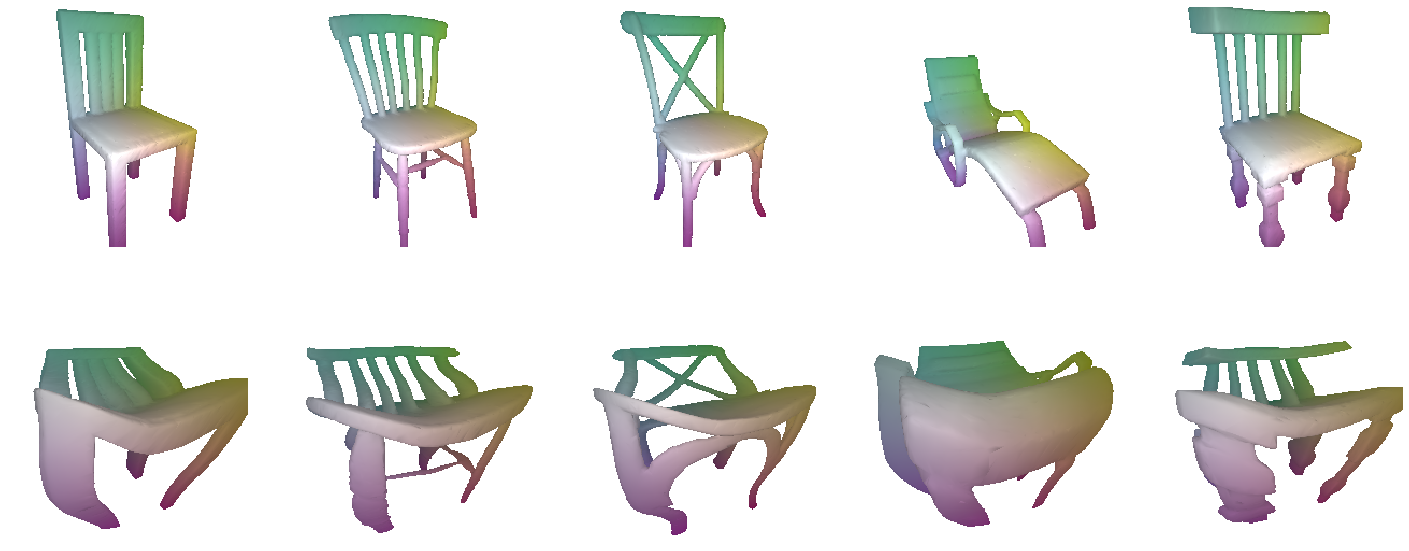

In [14]:
# Rendering view point
eye_1 = [.8, .4, .5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]

# colorize vertices based on mean shape coordinates
bboxes_d = [m.bounding_box.bounds for m in mesh_d]
bboxes_d = np.concatenate(bboxes_d, axis=0)
bboxes_d = np.stack([np.min(bboxes_d, axis=0), np.max(bboxes_d, axis=0)], axis=0)

for idx, (mo, md) in enumerate(zip(mesh_o, mesh_d)):
    color = (md.vertices.copy() - bboxes_d[0]) / (bboxes_d[1] - bboxes_d[0])
    md.visual.vertex_colors = color.copy()
    mo.visual.vertex_colors = color.copy()
    md_ = md.copy()#; md_.vertices *= 0.5
    mo_ = mo.copy()
    img_tar, _, _, _ = render.render_trimesh(md_, 2*np.array(eye_1), center, up, res=(224, 224))
    img_src, _, _, _ = render.render_trimesh(mo_, eye_1, center, up, res=(224, 224))
    
    imgs_src[idx] = img_src
    imgs_tar[idx] = img_tar
    
# plot transformation table
fig, axes = plt.subplots(figsize=(5*n, 10), nrows=2, ncols=n)
for i in range(n):
    axes[0, i].imshow(imgs_src[i])
    axes[1, i].imshow(imgs_tar[i])
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.show()